pip install tensorflow
pip install tfLearn
pip install opencv-python

train_dir - pega os dados do banco de training
test_dir -  pega os dados do banco de teste
img_size - muda o tamanho 
word_label - Se a word_label for igual a cat a array fica [1,0] (1 para gato e 0 para cachorro) e se for word_label igual a cachorro for [0,1] (0 para gato e 1 para cachorro)

In [4]:
#Imports e constantes para o processamento

import cv2
import numpy as np
import os
from random import shuffle

#train data
TRAIN_DIR = 'dogs-vs-cats/train'
#teste data
TEST_DIR = 'dogs-vs-cats/test1'
# tamanho da imagem
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic')

In [2]:
# Converter as imagens e labels para informação em array 
# cedula para pegar as imagens do banco e fazer a separação dog(cachorro) cat(gato)

def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]


In [3]:
# criando um training data
# Processar a imagem de training e as labesl para arrays

def create_train_data():
    training_data = []
    for img in os.listdir(TRAIN_DIR):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data


In [4]:
# Processando o test data
# imagens e numeros

#Com esta função, salvaremos e retornaremos os dados do array. Deste jeito,
#se mudarmos apenas a estrutura da rede neural, e não algo com as imagens,
#como o tamanho da imagem..etc..então podemos apenas carregar o arquivo array e economizar algum tempo de processamento. Enquanto estamos aqui,
#podemos também criar uma função para processar os dados de teste. Estes são os dados reais do teste de competição,
#  não os dados que usaremos para verificar a precisão do nosso algoritmo durante o teste. Esses dados não têm rótulo.

# Essa função salva e retorna o dado da array. 

def process_test_data():
    testing_data = []
    for img in os.listdir(TEST_DIR):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [7]:
 # aqui roda o training
 #train_data = create_train_data()
# if you already have train data:
 train_data = np.load('train_data.npy')


ValueError: Object arrays cannot be loaded when allow_pickle=False

 
 Definir a rede neural

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


O que temos aqui é uma boa rede neural convolucional de 2 camadas, com uma camada totalmente conectada e, em seguida, a camada de saída. Tem sido debatido se uma camada totalmente conectada é útil ou não. Mas vamos deixar

Este convnet exato foi bom o suficiente para reconhecer dígitos escritos à mão 28x28. Vamos ver como ele se sai com gatos e cachorros na resolução 50x50.

1 epochs é o conjunto de dados é passado na rede neural UMA VEZ.

no nosso codigo var ter 5 epochs assim os dados vão passar 5 vezes


Agora, nem sempre será o caso de você estar treinando a rede toda vez. Talvez primeiro você queira apenas ver como 3 épocas treinam, mas então, depois de 3, talvez você tenha terminado, ou talvez queira ver cerca de 5 épocas. Queremos salvar nosso modelo após cada sessão e recarregá-lo se tivermos uma versão salva, então adicionarei isto. 

Esse if serve para isso 

In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

Dividir os train_data

In [8]:
train = train_data[:-500]
test = train_data[-500:]

Agora, os dados de treinamento e os dados de teste são conjuntos de dados rotulados. Os dados de treinamento são os que ajustaremos à rede neural e os dados de teste são os que usaremos para validar os resultados. Os dados de teste estarão "fora da amostra", o que significa que os dados de teste serão usados apenas para testar a precisão da rede, não para treiná-la.

Em seguida, vamos criar nossas matrizes de dados. Por alguma razão, lógica numpy típica como:

array[:,0] e array[:,1]

as epochs que "fazem" a melhora da acuracia

In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 11.65576 | time: 47.090s
| Adam | epoch: 003 | loss: 11.65576 - acc: 0.4938 -- iter: 24448/24500
Training Step: 1149  | total loss: 11.31767 | time: 48.204s
| Adam | epoch: 003 | loss: 11.31767 - acc: 0.5085 | val_loss: 11.78924 - val_acc: 0.4880 -- iter: 24500/24500
--


In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')




Instructions for updating:
non-resource variables are not supported in the long term


NameError: name 'input_data' is not defined

In [12]:
model.save(MODEL_NAME)

INFO:tensorflow:c:\Users\sofia\Desktop\IaMl\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


NameError: name 'model' is not defined

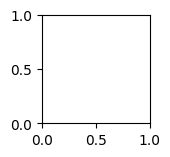

In [5]:
import matplotlib.pyplot as plt

# if you need to create the data:
# test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy', allow_pickle=True)

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

falta acrescentar no projeto flip, rotate e predict 